In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np

URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/items.zip'

url = urlopen(URL)
output = open('items.zip','wb')
output.write(url.read())
output.close()

zip_ref = ZipFile('items.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [0]:
# Import data and keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Dense, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Dropout, BatchNormalization, Activation, SpatialDropout2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import os

files = os.listdir('./dataset/items')
for name in files:
    print(name)

items_label.npy
items_image.npy


In [0]:
x1_raw = np.load('./dataset/items/items_image.npy')
y1_raw = np.load('./dataset/items/items_label.npy')

x1_test = np.array([])
y1_test = np.array([])

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

In [0]:
filterLbls = ['items_weapon','items_weapons','items_weapon_ranged','items_weapon_artefact']
#'items_wand','items_staff','items_rod'

y1_train = []

firstTime = True
for i in range(y1_raw.shape[0]):
  
  if y1_raw[i] in filterLbls:
    y1_train.append(y1_raw[i])
    
    if firstTime:
      firstTime = False
      raw = x1_raw[i,:,:,:]
      x1_train = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
    else:
      raw = x1_raw[i,:,:,:]
      raw = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
      x1_train = np.concatenate((x1_train,raw), axis=0)
    
y1_train = np.array(y1_train)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  featurewise_center = True,
  featurewise_std_normalization = True,
  rotation_range = 60,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2
)

datagen.fit(x1_train)

In [0]:
#Encoder1
inputShape = (32,32,4)

encoder1 = Sequential()
encoder1.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=inputShape)) 
encoder1.add(SpatialDropout2D(0.25))
encoder1.add(Conv2D(32, (3,3), strides=(2,2), activation='relu', padding='same'))
encoder1.add(Conv2D(64, (3,3), strides=(2,2), activation='relu', padding='same'))

print(encoder1.summary())

#Decoder1
codeShape1 = (8,8,64)

decoder1 = Sequential()
decoder1.add(Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape1))
decoder1.add(Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same'))
decoder1.add(Conv2DTranspose(4, (3,3), activation='sigmoid', padding='same'))

print(decoder1.summary())

#Autoencoder1
inputImage1 = Input(shape=inputShape)
x = encoder1(inputImage1)
x = decoder1(x)
autoencoder1 = Model(inputImage1, x)
print(autoencoder1.summary())
print(x1_train.shape)
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        592       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
Total params: 23,728
Trainable params: 23,728
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 32)        18464     
_________________________________________________________________
c

In [0]:
encoder1.trainable = True
decoder1.trainable = True
autoencoder1.trainable = True

history = autoencoder1.fit(x1_train, x1_train, epochs=10, batch_size=1, shuffle=True)

Epoch 1/10
511/511 [==============================] - 8s 16ms/step - loss: 0.2838
Epoch 2/10
511/511 [==============================] - 7s 13ms/step - loss: 0.1656
Epoch 3/10
511/511 [==============================] - 6s 13ms/step - loss: 0.1413
Epoch 4/10
511/511 [==============================] - 6s 12ms/step - loss: 0.1377
Epoch 5/10
511/511 [==============================] - 6s 12ms/step - loss: 0.1326
Epoch 6/10
511/511 [==============================] - 6s 12ms/step - loss: 0.1234
Epoch 7/10
511/511 [==============================] - 7s 14ms/step - loss: 0.1156
Epoch 8/10
511/511 [==============================] - 7s 14ms/step - loss: 0.1171
Epoch 9/10
511/511 [==============================] - 7s 13ms/step - loss: 0.1100
Epoch 10/10
511/511 [==============================] - 8s 16ms/step - loss: 0.1083


(32, 32, 4)
(32, 32, 4)


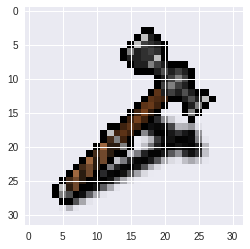

In [0]:
import random
x = random.randint(0,511)
randImg = np.reshape(x1_train[x], (1, 32, 32, 4)) 

resultImg = encoder1.predict(randImg, batch_size=1)
resultImg = decoder1.predict(resultImg, batch_size=1)
randImg = randImg.reshape(32,32,4)
resultImg = resultImg.reshape(32,32,4)

print(randImg.shape)
print(resultImg.shape)
from matplotlib import pyplot as plt
origFig = plt.imshow(randImg)



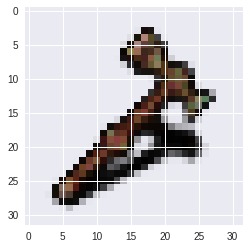

In [0]:
resFig = plt.imshow(resultImg)

In [0]:
# AutoEncoder 2

x2_train = encoder1.predict(np.reshape(x1_train,(len(x1_train),32,32,4)))
encoder2 = Sequential()
encoder2.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=codeShape1)) 
encoder2.add(SpatialDropout2D(0.25))
encoder2.add(Conv2D(128, (3,3), strides=(2,2), activation='relu', padding='same'))
#encoder2.add(Conv2D(256, (3,3), strides=(2,2), activation='relu', padding='same'))

codeShape2 = (4,4,128)
decoder2 = Sequential()
decoder2.add(Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape2))
#decoder2.add(Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same'))
#decoder2.add(Conv2DTranspose(4, (3,3), activation='sigmoid', padding='same'))

print(encoder2.summary())
print(decoder2.summary())

inputImage2 = Input(shape=codeShape1)
x = encoder2(inputImage2)
x = decoder2(x)
autoencoder2 = Model(inputImage2, x)
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
Total params: 110,784
Trainable params: 110,784
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 64)          73792     
Total params: 73,792
Trainable params: 73,792
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
encoder1.trainable = False
decoder1.trainable = False
autoencoder1.trainable = False
encoder2.trainable = True
decoder2.trainable = True
autoencoder2.trainable = True

history = autoencoder2.fit(x2_train, x2_train, epochs=10, batch_size=1, shuffle=True)

Epoch 1/10
511/511 [==============================] - 5s 10ms/step - loss: -3.4571
Epoch 2/10
511/511 [==============================] - 5s 10ms/step - loss: -4.1726
Epoch 3/10
511/511 [==============================] - 4s 9ms/step - loss: -4.2921
Epoch 4/10
511/511 [==============================] - 5s 9ms/step - loss: -4.3728
Epoch 5/10
511/511 [==============================] - 4s 8ms/step - loss: -4.4195
Epoch 6/10
511/511 [==============================] - 4s 8ms/step - loss: -4.4558
Epoch 7/10
511/511 [==============================] - 5s 9ms/step - loss: -4.4810
Epoch 8/10
511/511 [==============================] - 5s 9ms/step - loss: -4.4977
Epoch 9/10
511/511 [==============================] - 5s 9ms/step - loss: -4.5179
Epoch 10/10
511/511 [==============================] - 4s 8ms/step - loss: -4.5294


(32, 32, 4)
(32, 32, 4)


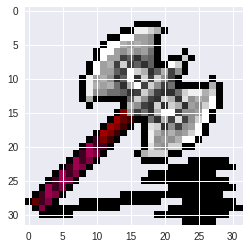

In [0]:
import random
x = random.randint(0,511)
randImg = np.reshape(x1_train[x], (1, 32, 32, 4)) 

resultImg = decoder1.predict(decoder2.predict(encoder2.predict(encoder1.predict(randImg))))
randImg = randImg.reshape(32,32,4)
resultImg = resultImg.reshape(32,32,4)

print(randImg.shape)
print(resultImg.shape)
from matplotlib import pyplot as plt
origFig = plt.imshow(randImg)


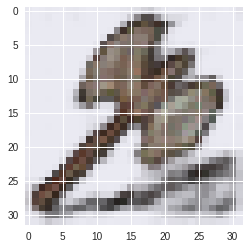

In [0]:
resFig = plt.imshow(resultImg)

In [0]:
#Merge

encoder = Sequential()
encoder.add(encoder1)
encoder.add(encoder2)

decoder = Sequential()
decoder.add(decoder2)
decoder.add(decoder1)

inputImage1 = Input(shape=inputShape)
x = encoder(inputImage1)
x = decoder(x)
autoencoder = Model(inputImage1, x)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 128)         134512    
_________________________________________________________________
sequential_6 (Sequential)    (None, 32, 32, 4)         97460     
Total params: 231,972
Trainable params: 184,576
Non-trainable params: 47,396
_________________________________________________________________
None


In [0]:
encoder.trainable = True
decoder.trainable = True
autoencoder.trainable = True
history = autoencoder.fit(x1_train, x1_train, epochs=100, batch_size=1, shuffle=True)

Epoch 1/100
511/511 [==============================] - 6s 12ms/step - loss: 0.1791
Epoch 2/100
511/511 [==============================] - 6s 11ms/step - loss: 0.1706
Epoch 3/100
511/511 [==============================] - 6s 11ms/step - loss: 0.1613
Epoch 4/100
511/511 [==============================] - 6s 12ms/step - loss: 0.1573
Epoch 5/100
511/511 [==============================] - 6s 11ms/step - loss: 0.1556
Epoch 6/100
511/511 [==============================] - 6s 12ms/step - loss: 0.1581
Epoch 7/100
511/511 [==============================] - 6s 11ms/step - loss: 0.1544
Epoch 8/100
511/511 [==============================] - 5s 10ms/step - loss: 0.1528
Epoch 9/100
511/511 [==============================] - 6s 11ms/step - loss: 0.1523
Epoch 10/100
511/511 [==============================] - 6s 12ms/step - loss: 0.1509
Epoch 11/100
511/511 [==============================] - 6s 11ms/step - loss: 0.1512
Epoch 12/100
511/511 [==============================] - 6s 12ms/step - loss: 0.1498
E

(32, 32, 4)
(32, 32, 4)


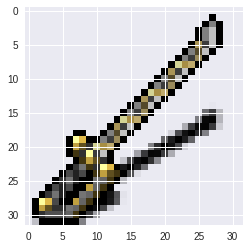

In [0]:
import random
x = random.randint(0,511)
randImg = np.reshape(x1_train[x], (1, 32, 32, 4)) 

resultImg = autoencoder.predict(randImg, batch_size=1)
randImg = randImg.reshape(32,32,4)
resultImg = resultImg.reshape(32,32,4)

print(randImg.shape)
print(resultImg.shape)
from matplotlib import pyplot as plt
origFig = plt.imshow(randImg)

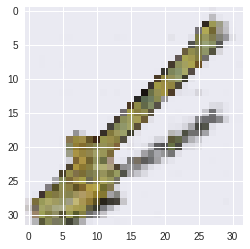

In [0]:
resFig = plt.imshow(resultImg)

In [0]:
# Creating the generator
generator = Sequential()
generator.add(Dense(512*2*2, activation='relu', input_dim = 100))
generator.add(BatchNormalization())
generator.add(Reshape((2, 2, 512)))
generator.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', activation='relu'))

print(generator.summary())
generator.compile(loss = 'binary_crossentropy', optimizer = adam)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 128)         1638528   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 64)          204864    
Total params: 2,058,944
Trainable params: 2,054,592
Non-trainable params: 4,352
______________________________________________________________

In [0]:
# Creating the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (8, 8, 64)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(256, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation = 'sigmoid'))

print(discriminator.summary())
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 4, 4, 64)          102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

In [0]:
# Create the GAN
decoder.trainable = False
encoder.trainale = False
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(decoder)
gan.add(encoder)
gan.add(discriminator)

encoder.trainable = False
decoder.trainable = False
autoencoder.trainable = False

gan.compile(loss = 'binary_crossentropy', optimizer = adam)
print(gan.summary())

ValueError: ignored

In [0]:
# Visualize generated data
def plotGeneratedImages():
  generated_images = decoder.predict(generator.predict(noise))
  fig = plt.figure(figsize=(9, 9))        
  for i in range(9 if generated_images.shape[0] > 9 else generated_images.shape[0]):
    plt.subplot(3, 3, i+1)
    img = np.clip(generated_images[i, :],0,1)
    img = img.reshape((32, 32, 4))
    plt.tight_layout()
    plt.imshow(img)
    plt.axis('off')

In [0]:
epochs = 1000
batch_size = 128

batch_count = int(x1_train.shape[0] / batch_size)

iterator = datagen.flow(x1_train, batch_size=batch_size)

for epoch in range(epochs):

    for index in tqdm(range(batch_count)):
        
        # Real images
        image_batch = x1_train[index * batch_size: (index + 1) * batch_size]
        #image_batch = iterator.next()
        
        # Get initial random input for generator
        noise = np.random.uniform(-1, 1, size=[batch_size, 100])
        
        # Generating images
        generated_data = generator.predict_on_batch(noise)
        generated_data = decoder.predict_on_batch(generated_data)

        # Train discriminator
        X = np.concatenate((image_batch,generated_data))
        y = np.concatenate((np.zeros(image_batch.shape[0]),np.ones(batch_size)))
        
        X = encoder.predict_on_batch(X)
        
        discriminator.trainable = True
        discriminator.train_on_batch(x=X, y=y)
        
        # Train generator 
        y = np.zeros(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(x=noise, y=y)
        
        img = generated_images = decoder.predict(generator.predict(noise))
        
    
plotGeneratedImages()


In [0]:
noise = np.random.uniform(-1, 1, size=[9, 100])
plotGeneratedImages()